In [1]:
import os
import gc
from joblib import dump, load
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# load files

In [2]:
train = pd.read_parquet("../input/train_full_features.parquet")

# define loss and metric

In [3]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# define training config

In [4]:
features = load("selected_features.pkl")

cat_features_base = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
] 
cat_features = [
    "{}_last".format(feature) for feature in cat_features_base
]
cat_features = [feature for feature in cat_features if feature in features]
            
target = "target"

In [5]:
train.head()

,customer_ID,B_30_count,B_30_last,B_30_nunique,B_38_count,B_38_last,B_38_nunique,D_114_count,D_114_last,D_114_nunique,...,D_137_drawup_duration,D_138_drawup_duration,D_139_drawup_duration,D_140_drawup_duration,D_141_drawup_duration,D_142_drawup_duration,D_143_drawup_duration,D_144_drawup_duration,D_145_drawup_duration,target
0,-9223358381327749917,13,0,2,13,6,3,13,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1
1,-9223193039457028513,13,0,1,13,0,1,13,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-9223189665817919541,13,0,1,13,0,1,13,0,1,...,0.0,0.0,0.0,0.0,7.0,12.0,0.0,9.0,0.0,0
3,-9223188534444851899,13,0,1,13,0,1,13,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0
4,-9223173911659837606,13,1,1,13,6,2,13,1,2,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1


In [6]:
seed = 1024
n_folds = 5

xgb_parms = { 
    "max_depth": 8, 
    "learning_rate": 0.01, 
    "subsample": 0.5,
    "colsample_bytree": 0.2, 
#     "gamma": 1.5,
#     "reg_lambda": 70,
    "min_child_weight": 0,
    "eval_metric": "logloss",
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "gpu_id": 1,
    # "booster": "dart",
    # "rate_drop": 0.1,
    # "skip_drop": 0.5,
    "num_parallel_tree": 5,
    "predictor": "gpu_predictor",
    "random_state": seed
}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(seed)

In [7]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = pd.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [8]:
def training(train):

    importances = []
    
    # create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))

    kfold = StratifiedKFold(
        n_splits=n_folds, 
        shuffle=True, 
        random_state=seed
    )
    
    for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

        print("#"*100)
        print("Training fold {} with {} features...".format(fold, len(features)))
        
        x_train= train.loc[trn_ind, features]
        y_train= train.loc[trn_ind, target]
        x_val = train.loc[val_ind, features]
        y_val = train.loc[val_ind, target]

        # xgb_train = xgb.DeviceQuantileDMatrix(xy_train, max_bin=256)
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_val = xgb.DMatrix(data=x_val, label=y_val)

        model = xgb.train(
            xgb_parms, 
            dtrain=xgb_train,
            evals=[(xgb_train,"train"),(xgb_val,"valid")],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100
        ) 
        model.save_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

        # importance
        importance = model.get_score(importance_type="weight")
        importances.append(pd.DataFrame({"feature":importance.keys(), "importance_{}".format(fold):importance.values()}))

        # oof
        oof_preds = model.predict(xgb_val)
        score = amex_metric_mod(y_val.values, oof_preds)
        print("fold {} score is {}".format(fold, score))
        
        # add to out of folds array
        oof_predictions[val_ind] = oof_preds

        del x_train, y_train, x_val, y_val, xgb_train, xgb_val, model, importance, oof_preds
        _ = gc.collect()
    
    # compute oof
    score = amex_metric_mod(train[target], oof_predictions)
    print("oof score is {}".format(score))
    
    # create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({"customer_ID": train["customer_ID"], "target": train[target], "prediction": oof_predictions})
    oof_df.to_parquet("xgb_oof_{}.parquet".format(seed))
    
    return importances, oof_df

In [9]:
importances, oof_df = training(train)

####################################################################################################
Training fold 0 with 1950 features...
[0]	train-logloss:0.68655	valid-logloss:0.68662
[100]	train-logloss:0.35687	valid-logloss:0.36281
[200]	train-logloss:0.26348	valid-logloss:0.27417
[300]	train-logloss:0.22922	valid-logloss:0.24416
[400]	train-logloss:0.21377	valid-logloss:0.23260
[500]	train-logloss:0.20494	valid-logloss:0.22746
[600]	train-logloss:0.19826	valid-logloss:0.22460
[700]	train-logloss:0.19271	valid-logloss:0.22275
[800]	train-logloss:0.18790	valid-logloss:0.22149
[900]	train-logloss:0.18360	valid-logloss:0.22056
[1000]	train-logloss:0.17962	valid-logloss:0.21985
[1100]	train-logloss:0.17591	valid-logloss:0.21927
[1200]	train-logloss:0.17239	valid-logloss:0.21882
[1300]	train-logloss:0.16907	valid-logloss:0.21846
[1400]	train-logloss:0.16593	valid-logloss:0.21816
[1500]	train-logloss:0.16288	valid-logloss:0.21787
[1600]	train-logloss:0.15998	valid-logloss:0.21763
[1700]

[200]	train-logloss:0.26408	valid-logloss:0.27173
[300]	train-logloss:0.22982	valid-logloss:0.24142
[400]	train-logloss:0.21437	valid-logloss:0.22982
[500]	train-logloss:0.20552	valid-logloss:0.22463
[600]	train-logloss:0.19878	valid-logloss:0.22176
[700]	train-logloss:0.19321	valid-logloss:0.21997
[800]	train-logloss:0.18841	valid-logloss:0.21874
[900]	train-logloss:0.18414	valid-logloss:0.21785
[1000]	train-logloss:0.18024	valid-logloss:0.21715
[1100]	train-logloss:0.17661	valid-logloss:0.21663
[1200]	train-logloss:0.17313	valid-logloss:0.21619
[1300]	train-logloss:0.16984	valid-logloss:0.21583
[1400]	train-logloss:0.16677	valid-logloss:0.21553
[1500]	train-logloss:0.16380	valid-logloss:0.21527
[1600]	train-logloss:0.16089	valid-logloss:0.21504
[1700]	train-logloss:0.15806	valid-logloss:0.21485
[1800]	train-logloss:0.15536	valid-logloss:0.21468
[1900]	train-logloss:0.15268	valid-logloss:0.21453
[2000]	train-logloss:0.15010	valid-logloss:0.21439
[2100]	train-logloss:0.14762	valid-logl

# feature importance

In [10]:
importance = importances[0].copy()
for k in range(1, n_folds): 
    importance = importance.merge(importances[k], on="feature", how="left")
    
importance["importance"] = importance.iloc[:,1:].mean(axis=1)
importance = importance.sort_values("importance",ascending=False)

# importance.to_csv("xgb_feature_importance.csv",index=False)

In [11]:
importance

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
16,P_2_mean,20044.0,19525.0,17188.0,20666.0,19677.0,19420.00
20,P_2_last,18999.0,18826.0,16838.0,19400.0,18716.0,18555.80
18,P_2_min,18056.0,17307.0,15639.0,18217.0,17666.0,17377.00
19,P_2_max,11814.0,11852.0,10354.0,12181.0,11774.0,11595.00
54,D_43_mean,11129.0,10471.0,9941.0,10997.0,10604.0,10628.40
...,...,...,...,...,...,...,...
1379,D_108_max_drawup,2.0,NaN,NaN,NaN,NaN,2.00
1864,D_87_drawup_duration,2.0,NaN,1.0,2.0,1.0,1.50
1578,D_137_max_drawdown,1.0,NaN,1.0,1.0,2.0,1.25
1343,D_87_max_drawup,1.0,1.0,NaN,NaN,NaN,1.00


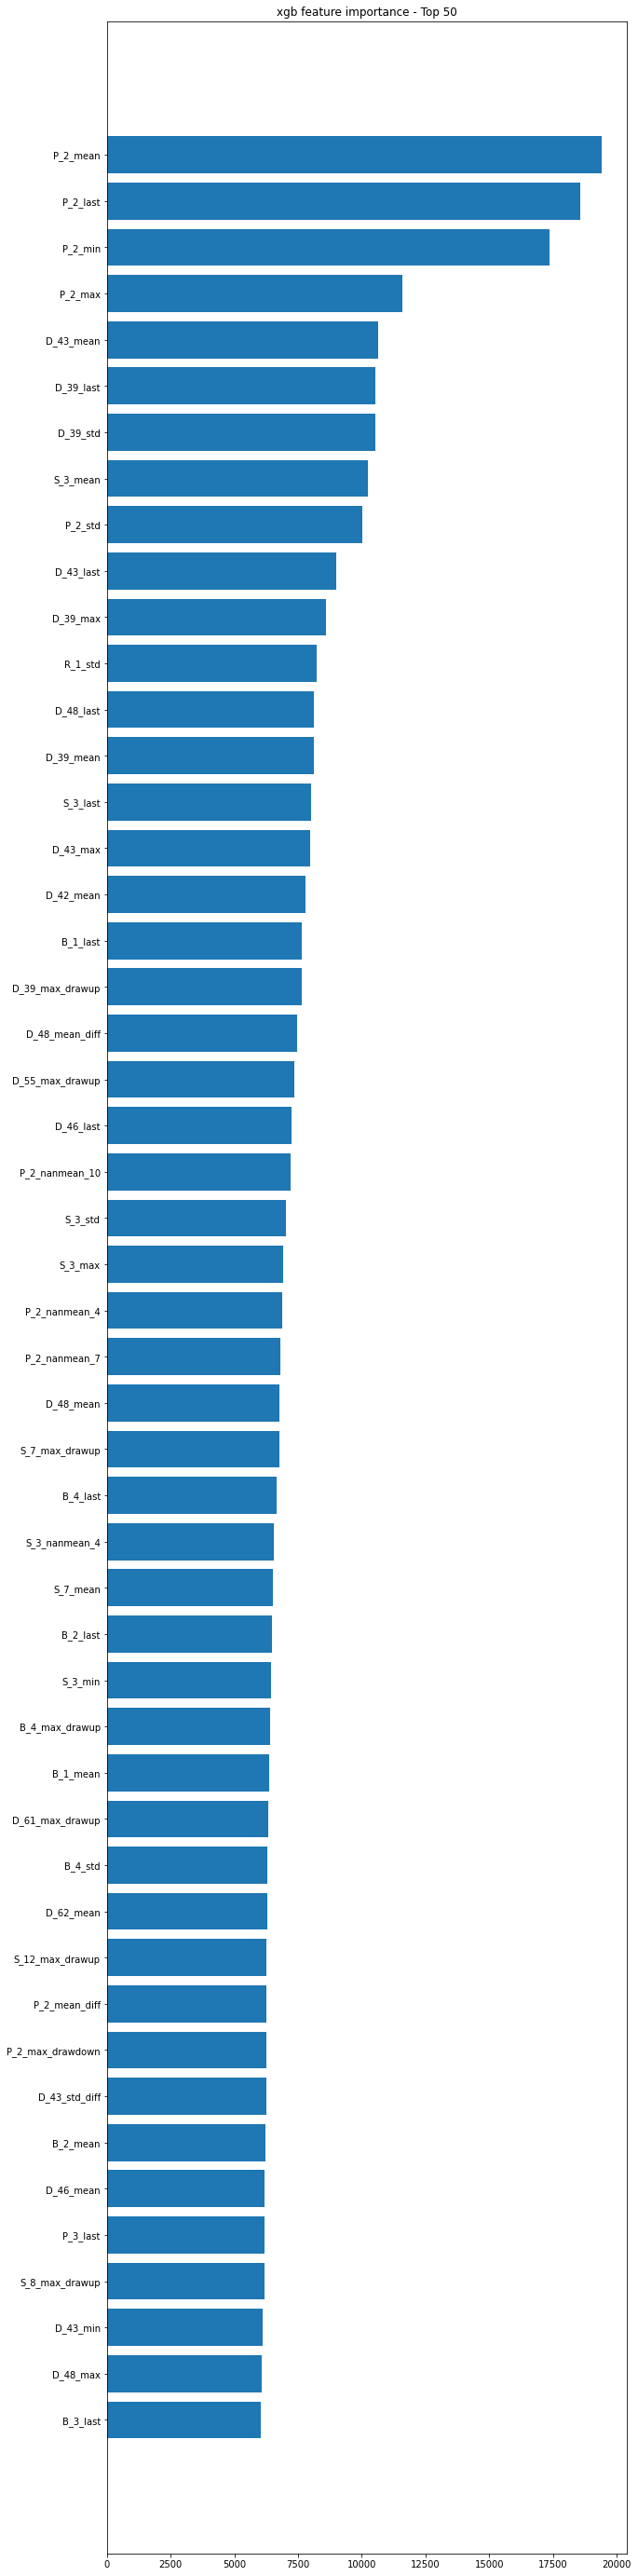

In [12]:
n_features = 50

plt.figure(figsize=(10, n_features))
plt.barh(np.arange(n_features, 0, -1), importance.importance.values[:n_features])
plt.yticks(np.arange(n_features,0,-1), importance.feature.values[:n_features])
plt.title("xgb feature importance - Top {}".format(n_features))
plt.show()

In [13]:
importance.head(50)

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
16,P_2_mean,20044.0,19525.0,17188.0,20666.0,19677.0,19420.0
20,P_2_last,18999.0,18826.0,16838.0,19400.0,18716.0,18555.8
18,P_2_min,18056.0,17307.0,15639.0,18217.0,17666.0,17377.0
19,P_2_max,11814.0,11852.0,10354.0,12181.0,11774.0,11595.0
54,D_43_mean,11129.0,10471.0,9941.0,10997.0,10604.0,10628.4
25,D_39_last,10724.0,10600.0,9877.0,11116.0,10425.0,10548.4
22,D_39_std,10667.0,10605.0,9824.0,11054.0,10414.0,10512.8
37,S_3_mean,10390.0,10373.0,9445.0,10675.0,10334.0,10243.4
17,P_2_std,10422.0,9840.0,8988.0,10858.0,9930.0,10007.6
57,D_43_last,8773.0,8899.0,8712.0,9565.0,8963.0,8982.4


In [14]:
P_2 = [col for col in importance["feature"] if "target" in col]

In [15]:
importance.loc[importance["feature"].isin(P_2)]

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
